# Exercise

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. First column: time (arbitrary units); second column: flux (arbitrary units); third column: homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level, described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

import pylab as py
import scipy.stats as stats
import corner

To start, I obtain the data from the file and I save the time, the flux and the flux uncertainty in three different arrays. Consequently, I plot the data in a time vs flux scatter plot, with the corresponding error bars.

In [2]:
data = np.load('/Users/beasa/Desktop/astrostatistics_bicocca_2024/solutions/transient.npy')

time = data[:, 0]
flux = data[:, 1]
flux_unc = data[:, 2]

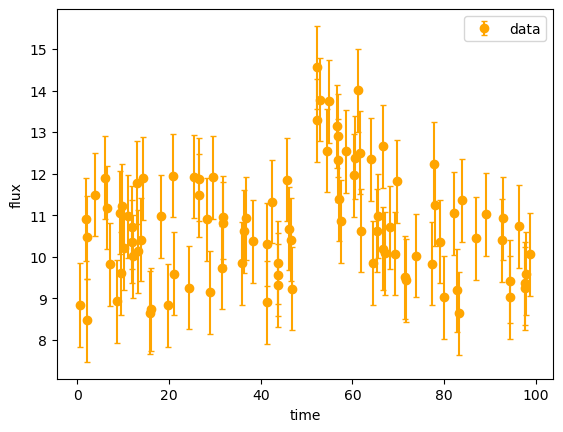

In [3]:
plt.errorbar(time, flux, yerr=flux_unc, xerr=None, fmt='o', capsize=2, ecolor='orange', color='orange', label='data')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

I define the function $model$ that returns the fit of the data. 

In [4]:
def model(tt, t_0, B, a, Alpha):
    if tt<t_0:
        return B
    else:
        return B+a*np.exp(-Alpha*(tt-t_0))

First of all, to fit the data I initialize by hand the parameters of the model and I define an array ($fluxGrid$) of values for the flux computed from my analytical model. Then, I plot the result with the data.

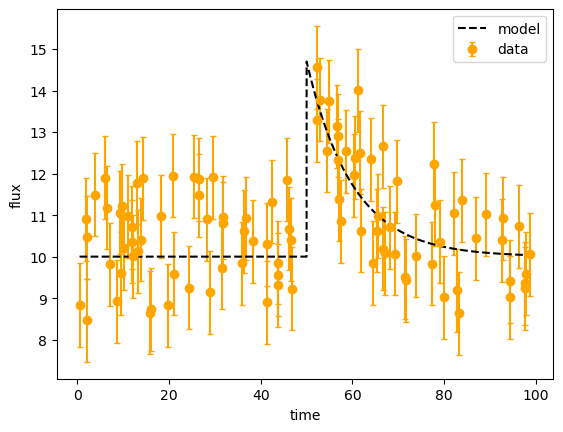

In [5]:
N = 10000
t = np.linspace(min(time), max(time), N)
t01 = 50
b1 = 10
A1 = 4.7
alpha1 = 0.1

fluxGrid = [model(tt, t01, b1, A1, alpha1) for tt in t]

plt.errorbar(time, flux, yerr=flux_unc, xerr=None, fmt='o', capsize=2, ecolor='orange', color='orange', label='data')
plt.plot(t, fluxGrid, color='black', ls='--', label='model')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

##### Bayesian analysis using emcee

First of all, I introduce the minimum and maximum values within which the distribution for each parameter is defined.

In [6]:
bmin, bmax = 0, 50
Amin, Amax = 0, 50
t0min, t0max = 0, 100
lnalphamin, lnalphamax = -5, 5
alphamin, alphamax = np.exp(lnalphamin), np.exp(lnalphamax)

Then, I define the functions for the logarithm of the likelihood, the logarithm of the prior and the logarithm of the posterior.

In [7]:
def log_likelihood(params, tt, Flux, flux_uncert):
    B, a, t_0, alpha2 = params
    Model = [model(T, t_0, B, a, alpha2) for T in tt]
    sigma1 = flux_uncert*flux_uncert
    
    return -np.sum((Flux-Model)*(Flux-Model)/sigma1)/2

# --------------------------------------------------------------------

def log_prior(params):
    B, a, t_0, alpha2 = params
    if bmin<B<bmax and Amin<a<Amax and t0min<t_0<t0max and alphamin<alpha2<alphamax:
        return 0.0
    
    return -np.inf

# --------------------------------------------------------------------

def log_posterior(params, tt, Flux, flux_uncert):
    return log_prior(params)+log_likelihood(params, tt, Flux, flux_uncert)

To make an MCMC analysis, I need an initial guess ($p0$) for the parameters of the model (this is the position from which we start the MCMC algotirhm), and I compute it by considering the previous initializations of the parameters and by adding a small perturbation.

In [8]:
nwalk = 24
ndim = 4  # it is the number of parameters (b, A, ln(alpha), t0)
nsteps = 7000
burnIn = 1500

# initial guesses
p0 = np.array([b1, A1, t01, alpha1])+1e-3*np.random.random((nwalk, ndim))

print(p0)

[[10.00086762  4.70079649 50.0008943   0.10052755]
 [10.00053736  4.70026645 50.00090038  0.10061879]
 [10.00016266  4.7002163  50.00060027  0.10090892]
 [10.00030672  4.70083957 50.00099478  0.10019017]
 [10.00078312  4.7008943  50.00014113  0.10016859]
 [10.00059476  4.70039417 50.00042057  0.10004557]
 [10.0009346   4.70053376 50.00029402  0.10071325]
 [10.00086218  4.70000608 50.00030314  0.10035395]
 [10.00041324  4.70039483 50.00082845  0.10004659]
 [10.00080465  4.70080438 50.00053488  0.10019282]
 [10.0002172   4.70084648 50.00070012  0.10078088]
 [10.00058042  4.70030112 50.0007535   0.10007491]
 [10.00017529  4.70026646 50.00056192  0.10023029]
 [10.00004692  4.70009844 50.00072737  0.10087402]
 [10.00007097  4.7007752  50.00075211  0.10035629]
 [10.0009879   4.70075106 50.00030165  0.10028795]
 [10.00007462  4.70004565 50.0006108   0.10018919]
 [10.00000263  4.70084372 50.00084355  0.10023732]
 [10.00059172  4.70062856 50.00011084  0.10086352]
 [10.00060932  4.70082733 50.00

In what follows, I firstly initialize the emcee EnsembleSampler, I run the chain by starting from the initial guess for each walker and then I get the chain flatten in a single array of samples ($.reshape(-1, ndim)$), after discarding the first burn in steps.

In [9]:
sampler = emcee.EnsembleSampler(nwalk, ndim, log_posterior, args=(time, flux, flux_unc))
sampler.run_mcmc(p0, nsteps)

emcee_trace = sampler.chain[:, burnIn:, :].reshape(-1, ndim)

print('done')

done


To be sure that everything works, I check wheter the length of the matrix $emcee\_trace$ is equal to the product between $(nsteps-burnIn)$ and $nwalk$.

In [10]:
variable = nsteps-burnIn
print(len(emcee_trace), variable*nwalk)
print(emcee_trace)

132000 132000
[[10.25731051  5.73179148 50.25436659  0.12188596]
 [10.29430573  5.56715985 50.47565487  0.13625026]
 [10.29430573  5.56715985 50.47565487  0.13625026]
 ...
 [10.3380916   6.43172191 49.1423534   0.14264912]
 [10.32167572  6.65252184 49.50633653  0.15375007]
 [10.30208296  6.0203473  49.92534694  0.14102622]]


I want now to make the trace plots. To do that I split the results in $emcee\_trace$ in four different arrays containing respectively the results of the MCMC analysis for the four parameters of the model ($b$, $A$, $t_0$, $ln(\alpha)$). Consequently, I plot the trace plots by showing also the mean value for each parameter.

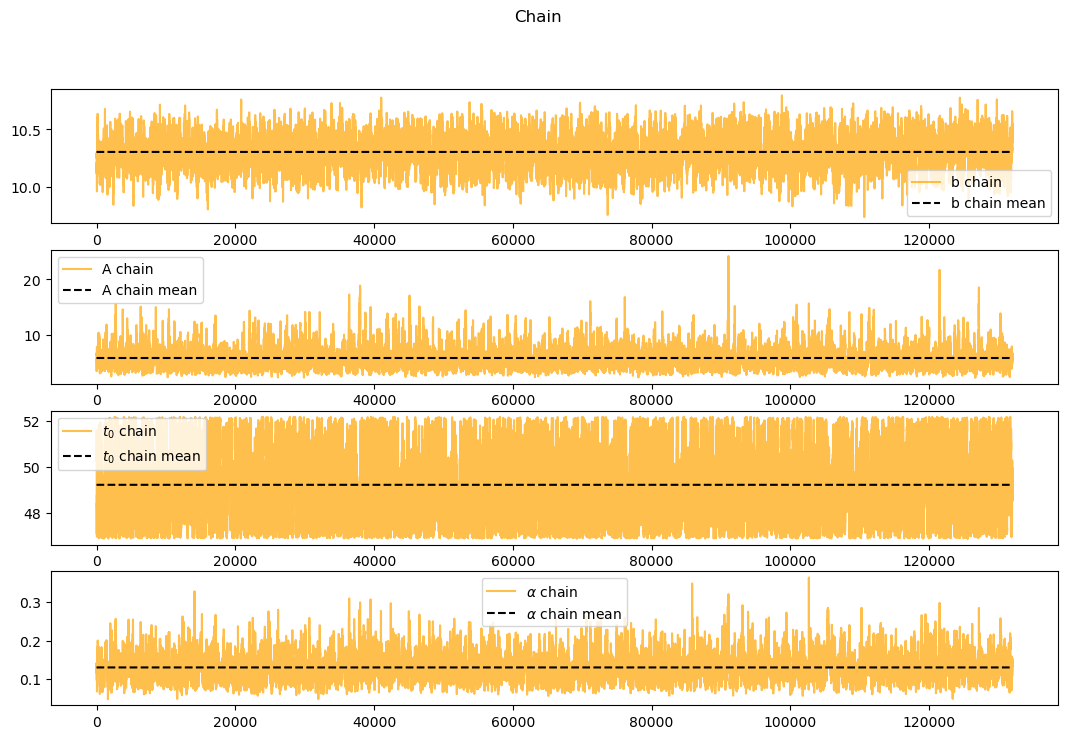

In [11]:
# b, A, t0, ln(alpha)

fig = plt.figure(figsize=(13, 8))

I_column = [row[0] for row in emcee_trace]  # b
II_column = [row[1] for row in emcee_trace]  # A
III_column = [row[2] for row in emcee_trace]  # t0
IV_column = [row[3] for row in emcee_trace]  # ln(alpha)

Size = len(I_column)
xgrid = np.linspace(1, Size, Size)

ax1 = fig.add_subplot(411)
ax1.plot(xgrid, I_column, color='orange', label='b chain', alpha=0.7)
meanCb = [np.mean(I_column)]*Size
ax1.plot(xgrid, meanCb, color='black', label='b chain mean', ls='--') 
ax1.legend()

ax2 = fig.add_subplot(412)
ax2.plot(xgrid, II_column, color='orange', label='A chain', alpha=0.7)
meanCA = [np.mean(II_column)]*Size
ax2.plot(xgrid, meanCA, color='black', label='A chain mean', ls='--') 
ax2.legend()

ax3 = fig.add_subplot(413)
ax3.plot(xgrid, III_column, color='orange', label=r'$t_0$ chain', alpha=0.7)
meanCt = [np.mean(III_column)]*Size
ax3.plot(xgrid, meanCt, color='black', label=r'$t_0$ chain mean', ls='--') 
ax3.legend()

ax4 = fig.add_subplot(414)
ax4.plot(xgrid, IV_column, color='orange', label=r'$\alpha$ chain', alpha=0.7)
meanClnalpha = [np.mean(IV_column)]*Size
ax4.plot(xgrid, meanClnalpha, color='black', label=r'$\alpha$ chain mean', ls='--') 
ax4.legend()

plt.suptitle('Chain')
plt.show()

To thin the chain by selecting only points every auto-correlation length, I compute the autocorrelation time and its maximum (which is the value that I use to select the points). Then, I define a new array of samples that I obtain from the previous one to which I remove the points that are correlated, based on the maximum autocorrelation time.

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[53.38611942 66.34002932 68.31608934 55.97876177]


In [13]:
extract = int(max(tau))
new_samples = sampler.get_chain(discard=2*extract, thin=extract, flat=True)
print(new_samples.shape)

(2400, 4)


In the following cell I represent the new sample (the one from which I have taken away the autocorrelated points) with a corner plot.

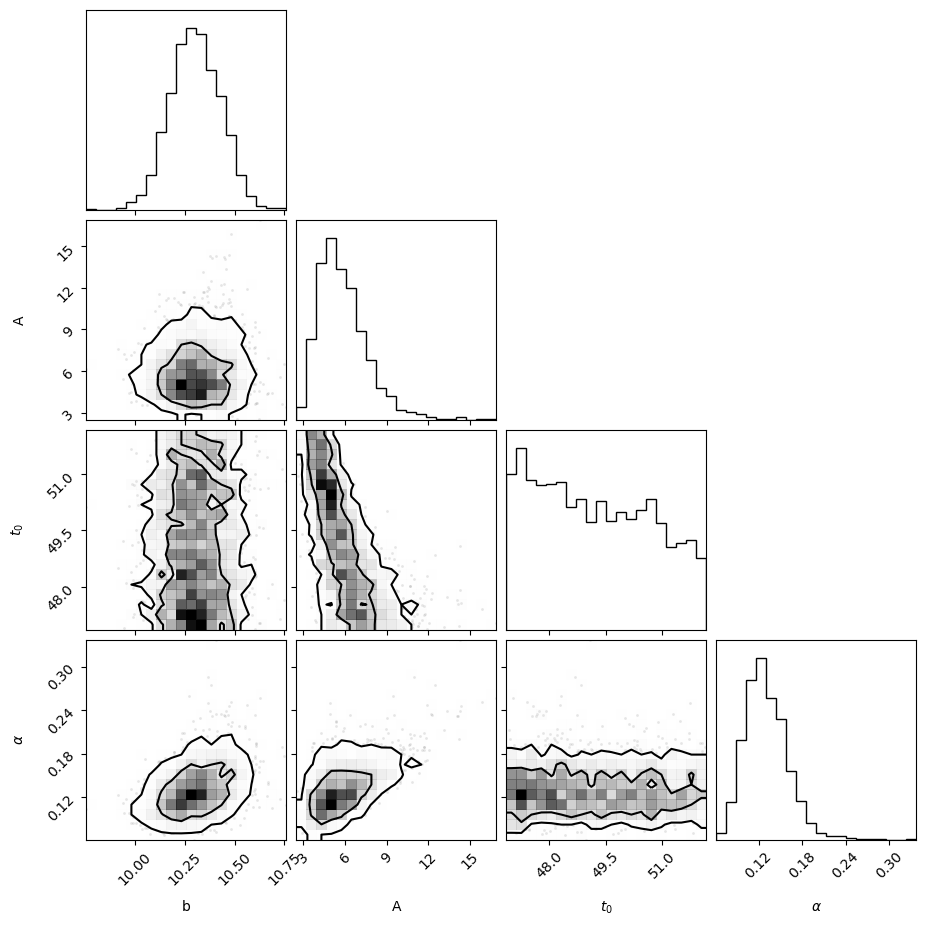

In [14]:
fig1 = corner.corner(new_samples, labels=['b', 'A', r'$t_0$', r'$\alpha$'], levels=[0.68, 0.95]);

I randomly choose $100$ samples from the chain, and I define a new array containing such points.

In [15]:
request = np.random.choice(len(new_samples), size=100)
random_100 = new_samples[request]

For each of these randomly chosen samples I compute the corresponding model and I plot it on the top of the data.

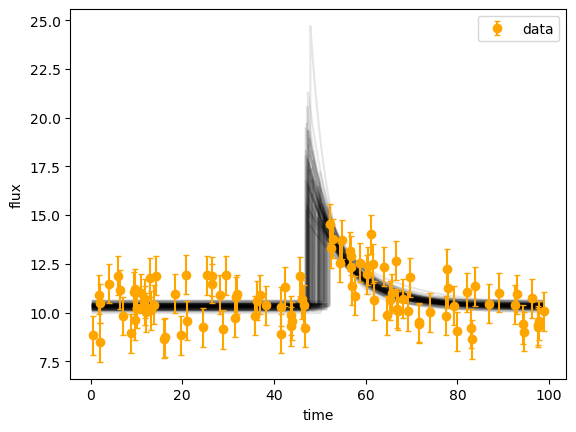

In [16]:
for q in random_100:
    bi, aa, time0, alpha3 = q
    result = [model(w, time0, bi, aa, alpha3) for w in t]
    plt.plot(t, result, alpha=0.1, color='black')

plt.errorbar(time, flux, yerr=flux_unc, xerr=None, fmt='o', capsize=2, ecolor='orange', color='orange', label='data')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

To conclude, I compute the median and the $90\%$ credible region of the marginalized distribution.

In [20]:
bvalue_5, bmedian, bvalue_95 = np.percentile(new_samples[:, 0], [5, 50, 95])
Avalue_5, Amedian, Avalue_95 = np.percentile(new_samples[:, 1], [5, 50, 95])
t0value_5, t0median, t0value_95 = np.percentile(new_samples[:, 2], [5, 50, 95])
alphavalue_5, alphamedian, alphavalue_95 = np.percentile(new_samples[:, 3], [5, 50, 95])

print('b value: ', bmedian, ' +', bvalue_95-bmedian, ' -', bmedian-bvalue_5)
print('A value: ', Amedian, ' +', Avalue_95-Amedian, ' -', Amedian-Avalue_5)
print('t0 value: ', t0median, ' +', t0value_95-t0median, ' -', t0median-t0value_5)
print('alhpa value: ', alphamedian, ' +', alphavalue_95-alphamedian, ' -', alphamedian-alphavalue_5)

b value:  10.302349882359294  + 0.20582827410551197  - 0.1955671901656384
A value:  5.552467806817839  + 3.571928136020462  - 1.957737683455695
t0 value:  49.096629154058405  + 2.65867013796327  - 2.012648676749201
alhpa value:  0.12754960228992634  + 0.05411417862893422  - 0.038015028551252425
